In [13]:
%load_ext autoreload
%autoreload 2
from tqdm import tqdm
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from IPython.display import Video

import sapien
import mani_skill.envs

from vega_robot import Vega

import torch

from mani_skill.utils.wrappers import RecordEpisode
from IPython.display import Video

np.set_printoptions(precision=2, suppress=True)
torch.set_printoptions(precision=2, sci_mode=False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Build Robot

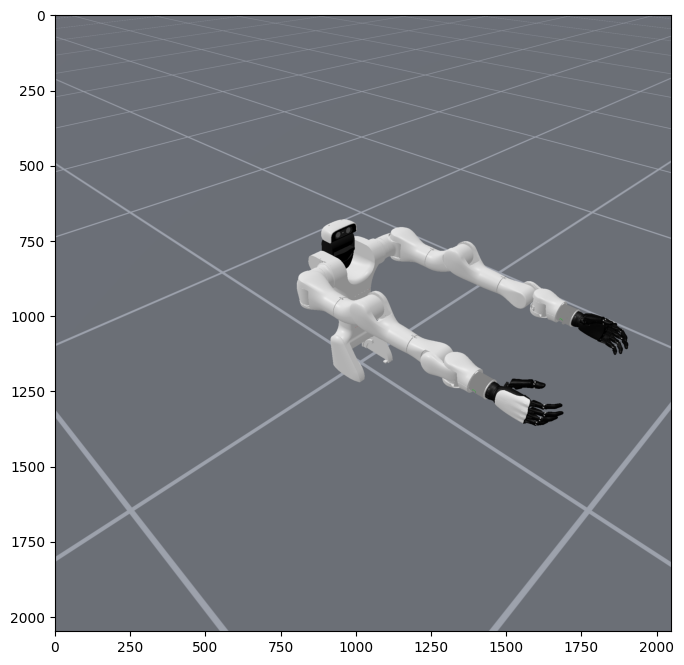

In [15]:
env = gym.make("Empty-v1", robot_uids="vega", render_mode="rgb_array")
env.action_space # shape (N, D)
env.observation_space # shape (N, ...)
env.reset()

# kf = env.agent.keyframes['rest']
# env.agent.robot.set_qpos(kf.qpos)
# env.agent.controller.reset()

plt.figure(figsize=(8, 8))
plt.imshow(env.render()[0].cpu().numpy())

In [3]:
# 检查关节顺序
from mani_skill.envs.scene import ManiSkillScene  
from mani_skill.utils.building import URDFLoader  
  
loader = URDFLoader()  
loader.set_scene(ManiSkillScene())  
# robot = loader.load("/home/xzhan742/Coding/ManiSkill/vega_grasp/dexmate-urdf/robots/humanoid/vega_1/vega_upper_body_no_effector.urdf")  
robot = loader.load("/home/xzhan742/Coding/ManiSkill/mani_skill/assets/robots/panda/panda_v2.urdf")  
import rich
rich.print(list(enumerate(robot.active_joints_map.keys())))
# print("\n".join(list(robot.active_joints_map.keys())))

2025-11-17 15:32:52,756 - mani_skill  - WARNING - No initial pose set for articulation builder of None, setting to default pose q=[1,0,0,0], p=[0,0,0]. There may be simulation issues/bugs if this articulation at it's initial pose collides with other objects at their initial poses.


[
    (0, 'panda_joint1'),
    (1, 'panda_joint2'),
    (2, 'panda_joint3'),
    (3, 'panda_joint4'),
    (4, 'panda_joint5'),
    (5, 'panda_joint6'),
    (6, 'panda_joint7'),
    (7, 'panda_finger_joint1'),
    (8, 'panda_finger_joint2')
]

In [4]:
env = gym.make("Empty-v1", robot_uids="vega",
                control_mode="pd_joint_delta_pos",
                render_mode="rgb_array")
# print(env.agent.robot.dof)
# print(env.agent.robot.active_joints)
# env.agent.robot.active_joints_map.keys()
# print(env.action_space)
env.agent.controller 

/home/xzhan742/miniconda3/envs/vegagrasp/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.agent to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.agent` for environment variables or `env.get_wrapper_attr('agent')` that will search the reminding wrappers.
  logger.warn(


CombinedController(dof=13, active_joints=39
    arm: PDJointPosController(dof=7, active_joints=7, joints=(R_arm_j1, R_arm_j2, R_arm_j3, R_arm_j4, R_arm_j5, R_arm_j6, R_arm_j7))
    hand_th_j0: PDJointPosController(dof=1, active_joints=1, joints=(R_th_j0))
    hand_mimic: PDJointPosMimicController(dof=5, active_joints=10, mimic_to_control_joint_map={
        R_ff_j2: R_ff_j1,
        R_mf_j2: R_mf_j1,
        R_rf_j2: R_rf_j1,
        R_lf_j2: R_lf_j1,
        R_th_j2: R_th_j1,
    })
    passive_joints: PassiveController(dof=21, active_joints=21, joints=(head_j1, L_arm_j1, head_j2, L_arm_j2, head_j3, L_arm_j3, L_arm_j4, L_arm_j5, L_arm_j6, L_arm_j7, L_th_j0, L_ff_j1, L_mf_j1, L_rf_j1, L_lf_j1, L_th_j1, L_ff_j2, L_mf_j2, L_rf_j2, L_lf_j2, L_th_j2))
)

In [5]:
env.reset()
obs, rew, terminated, truncated, info = env.step(env.action_space.sample())
# obs (N, ...), rew (N, ), terminated (N, ), truncated (N, )
print(obs)
print(rew)
print(terminated)
print(truncated)
print(info)

tensor([[ 0.00,  0.00, -0.08,  0.00,  0.00,  0.03,  0.00,  0.00,  0.01,  0.00,
         -0.18,  0.00,  0.02,  0.00, -0.08,  0.00, -0.15,  0.00,  0.00,  0.00,
          0.00,  0.00, -0.02, -0.00, -0.05, -0.04,  0.01,  0.00,  0.00,  0.00,
          0.00,  0.00, -0.02,  0.00, -0.06, -0.04,  0.01,  0.00, -0.03,  0.00,
          0.00, -1.40,  0.00,  0.00,  0.50,  0.00,  0.00,  0.21,  0.00, -2.71,
          0.00,  0.28,  0.00, -1.21,  0.00, -2.38,  0.00,  0.00,  0.00,  0.00,
          0.00, -0.00,  0.11, -0.79, -0.56,  0.24,  0.00,  0.00,  0.00,  0.00,
          0.00, -0.37,  0.02, -0.94, -0.69,  0.22,  0.00, -0.45]])
tensor([0.])
tensor([False])
tensor([False])
{'elapsed_steps': tensor([1], dtype=torch.int32)}


In [6]:
env = gym.make("Empty-v1", robot_uids="vega",
                control_mode="pd_joint_delta_pos",
                render_mode="rgb_array")
env = RecordEpisode(
    env,
    "./videos",
    max_steps_per_video=100
)

obs, _ = env.reset()
kf = env.agent.keyframes['rest']
env.agent.robot.set_qpos(kf.qpos)
env.agent.controller.reset()


for i in tqdm(range(200)):
    # action = np.ones(env.action_space.shape) * -0.1
    action = env.action_space.sample()
    action[:7] = 0
    # print(action)
    obs, reward, terminated, truncated, info = env.step(action)
    # print(obs)
env.close()

Video("./videos/0.mp4", embed=True, width=640) # Watch our replay

2025-11-17 15:32:53,268 - mani_skill  - WARNING - mani_skill is not installed with git.
/home/xzhan742/miniconda3/envs/vegagrasp/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.agent to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.agent` for environment variables or `env.get_wrapper_attr('agent')` that will search the reminding wrappers.
  logger.warn(
100%|██████████| 200/200 [00:05<00:00, 37.18it/s]


## Sensor

/home/xzhan742/miniconda3/envs/vegagrasp/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.print_sim_details to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.print_sim_details` for environment variables or `env.get_wrapper_attr('print_sim_details')` that will search the reminding wrappers.
  logger.warn(


# -------------------------------------------------------------------------- #
Task ID: Empty-v1, 1 parallel environments, sim_backend=physx_cpu
obs_mode=rgb+depth+segmentation, control_mode=pd_joint_delta_pos
render_mode=sensors, sensor_details=RGBD(128x128), RGBD(128x128), RGBD(128x128), RGBD(128x128)
sim_freq=100, control_freq=20
observation space: Dict('agent': Dict('qpos': Box(-inf, inf, (1, 39), float32), 'qvel': Box(-inf, inf, (1, 39), float32)), 'extra': Dict(), 'sensor_param': Dict('base_camera': Dict('extrinsic_cv': Box(-inf, inf, (1, 3, 4), float32), 'cam2world_gl': Box(-inf, inf, (1, 4, 4), float32), 'intrinsic_cv': Box(-inf, inf, (1, 3, 3), float32)), 'zed_depth_camera': Dict('extrinsic_cv': Box(-inf, inf, (1, 3, 4), float32), 'cam2world_gl': Box(-inf, inf, (1, 4, 4), float32), 'intrinsic_cv': Box(-inf, inf, (1, 3, 3), float32)), 'zed_left_camera': Dict('extrinsic_cv': Box(-inf, inf, (1, 3, 4), float32), 'cam2world_gl': Box(-inf, inf, (1, 4, 4), float32), 'intrinsic_cv': B

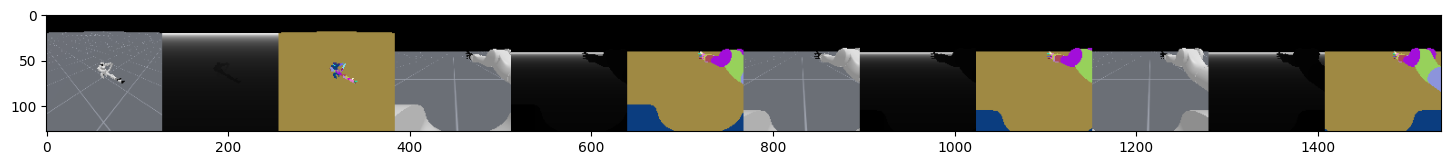

In [7]:
env = gym.make("Empty-v1", robot_uids="vega", control_mode="pd_joint_delta_pos", obs_mode="rgb+depth+segmentation",
                render_mode="sensors")
# env.agent.robot.links_map['head_l3']
# env.agent.sensors.keys()
env.print_sim_details()

obs, _ = env.reset()
kf = env.agent.keyframes['rest']
env.agent.robot.set_qpos(kf.qpos)

plt.figure(figsize=(18, 8))
plt.imshow(env.render()[0].cpu().numpy())

In [8]:
# obs["sensor_data"].keys()
# obs["sensor_data"]["zed_left_camera"].keys()
env.agent.robot.links_map.keys()

dict_keys(['torso_l3', 'arm_center', 'head_l1', 'L_arm_l1', 'R_arm_l1', 'head_l2', 'L_arm_l2', 'R_arm_l2', 'head_l3', 'L_arm_l3', 'R_arm_l3', 'zed_depth_frame', 'zed_left_camera', 'zed_right_camera', 'L_arm_l4', 'R_arm_l4', 'L_arm_l5', 'R_arm_l5', 'L_arm_l6', 'R_arm_l6', 'L_arm_l7', 'R_arm_l7', 'L_arm_l8', 'R_arm_l8', 'L_ee', 'L_hand_base', 'R_ee', 'R_hand_base', 'L_th_l0', 'L_ff_l1', 'L_mf_l1', 'L_rf_l1', 'L_lf_l1', 'R_th_l0', 'R_ff_l1', 'R_mf_l1', 'R_rf_l1', 'R_lf_l1', 'L_th_l1', 'L_ff_l2', 'L_mf_l2', 'L_rf_l2', 'L_lf_l2', 'R_th_l1', 'R_ff_l2', 'R_mf_l2', 'R_rf_l2', 'R_lf_l2', 'L_th_l2', 'L_ff_tip', 'L_mf_tip', 'L_rf_tip', 'L_lf_tip', 'R_th_l2', 'R_ff_tip', 'R_mf_tip', 'R_rf_tip', 'R_lf_tip', 'L_th_tip', 'R_th_tip'])

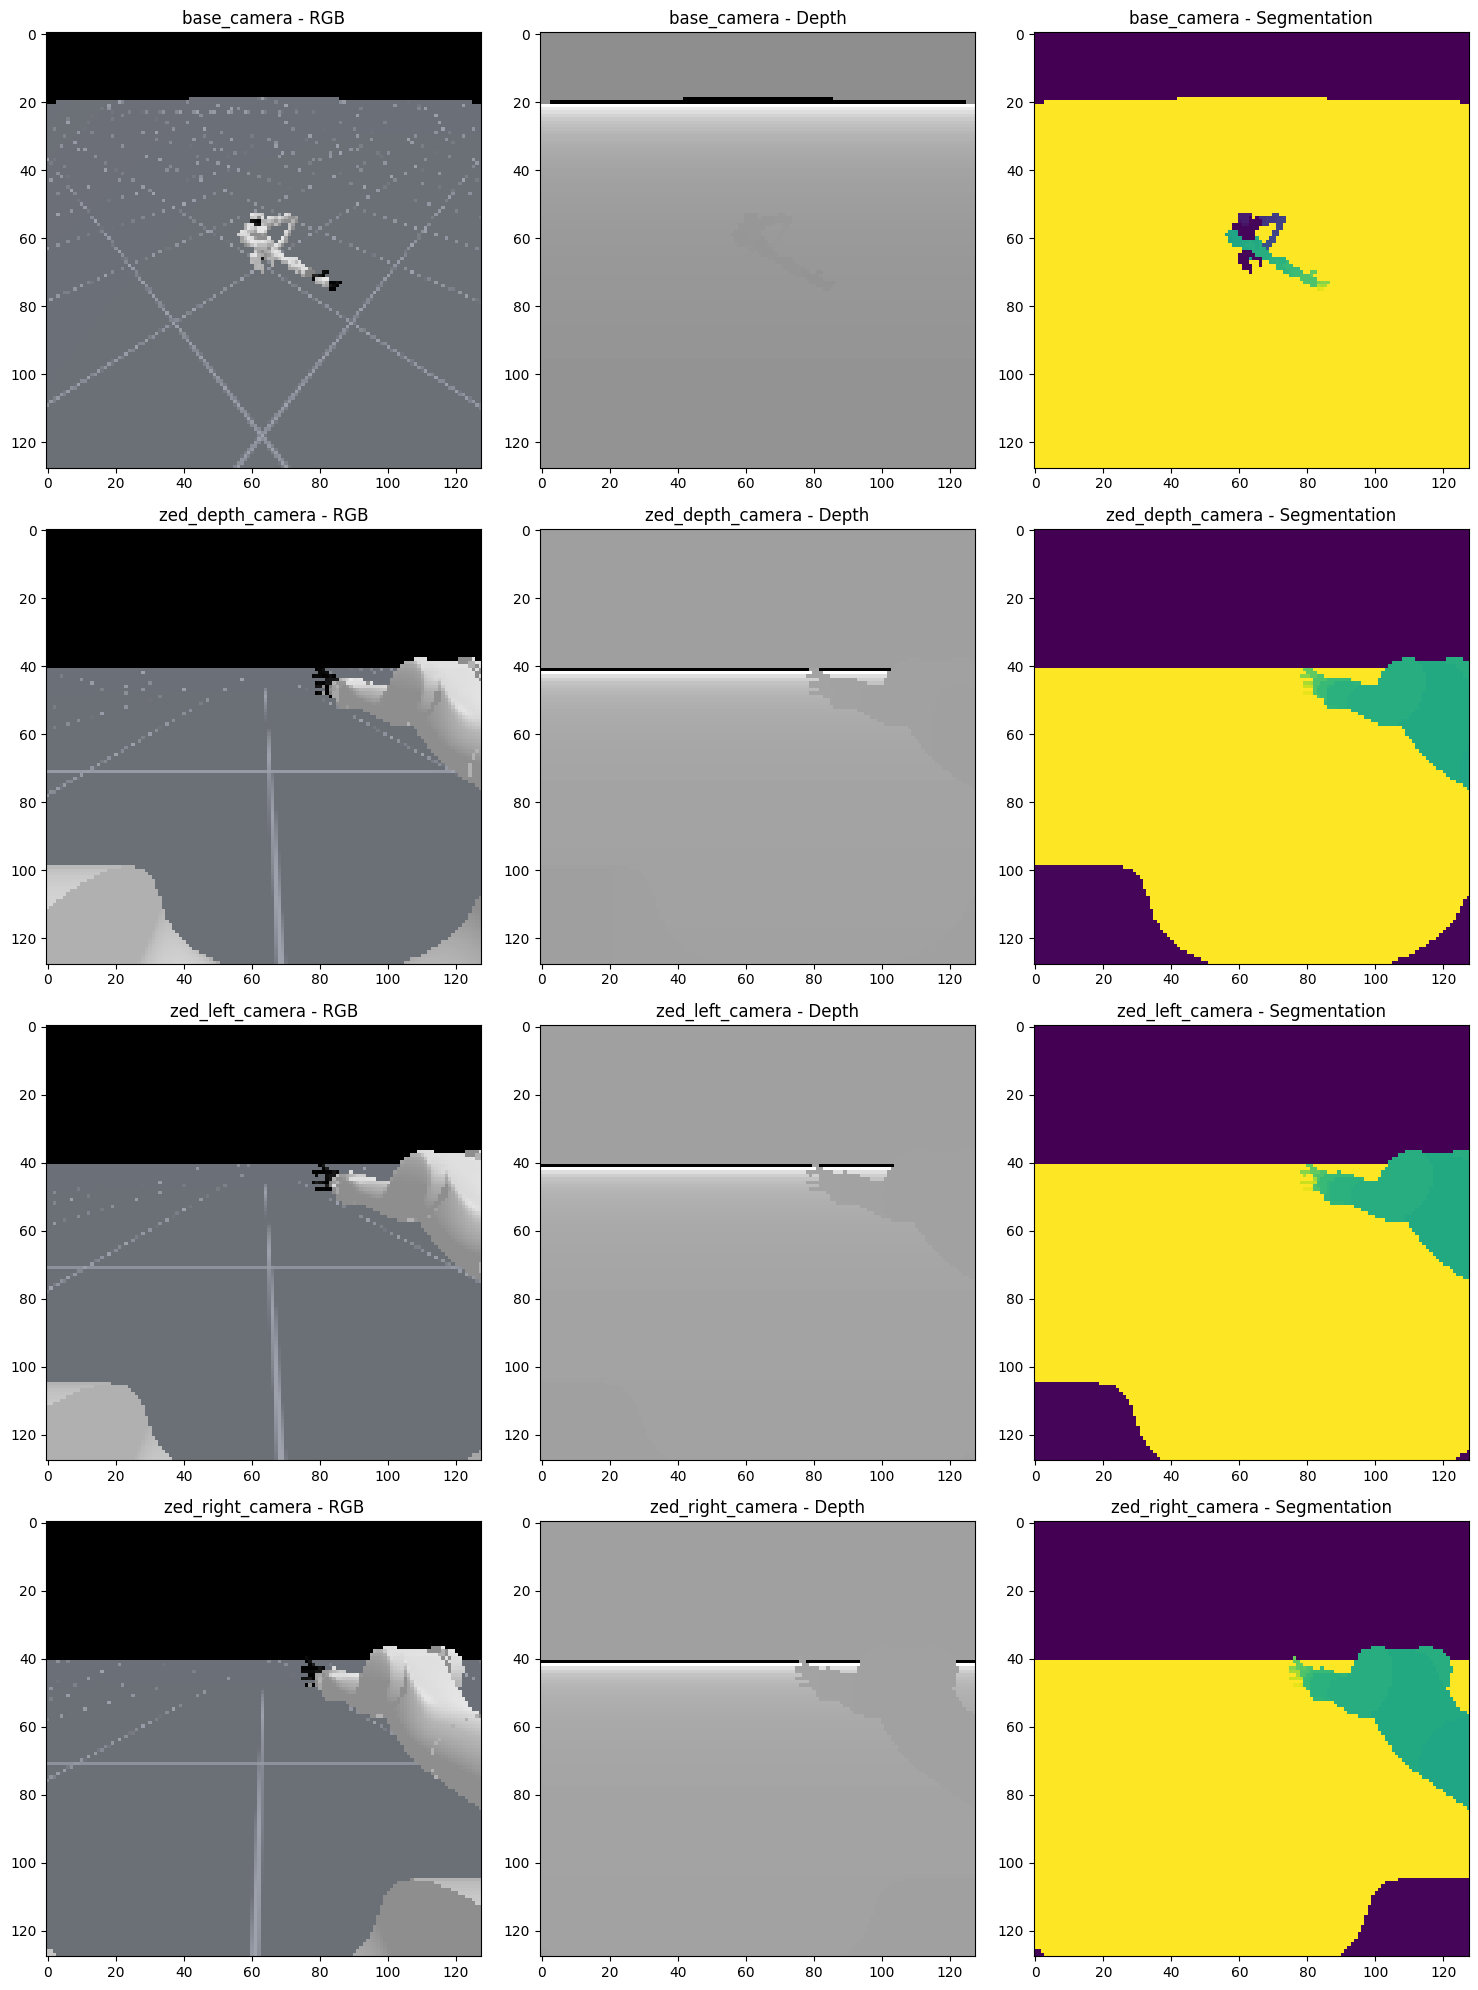

In [9]:
obs, _ = env.reset()
# kf = env.agent.keyframes['rest']
# env.agent.robot.set_qpos(kf.qpos)
obs, reward, terminated, truncated, info = env.step(np.zeros(env.action_space.shape))

n_cams = len(obs['sensor_data'])
plt.figure(figsize=(15, 5*n_cams))
env_id = 0
for i, (key, cam) in enumerate(obs['sensor_data'].items()):
    rgb, depth = cam['rgb'], cam['depth']
    plt.subplot(n_cams,3,1+3*i)
    plt.title(f"{key} - RGB")
    plt.imshow(rgb[env_id].cpu().numpy())
    plt.subplot(n_cams,3,2+3*i)
    plt.title(f"{key} - Depth")
    plt.imshow(depth[..., 0][env_id].cpu().numpy(), cmap="gray")
    plt.subplot(n_cams,3,3+3*i)
    plt.title(f"{key} - Segmentation")
    plt.imshow(cam["segmentation"][..., 0][env_id].cpu().numpy())
plt.tight_layout()

In [10]:
env = gym.make("Empty-v1", robot_uids="vega", control_mode="pd_joint_delta_pos",
                render_mode="sensors")
env = RecordEpisode(
    env,
    "./videos",
    max_steps_per_video=100
)

obs, _ = env.reset()
kf = env.agent.keyframes['rest']
_k_qpos = kf.qpos.copy()
env.agent.robot.set_qpos(_k_qpos)
env.agent.controller.reset()


for i in tqdm(range(100)):
    _k_qpos[0] -= 0.01
    env.agent.robot.set_qpos(_k_qpos)
    # action = np.ones(env.action_space.shape) * -0.1
    action = env.action_space.sample()
    action[:7] = 0
    # print(action)
    obs, reward, terminated, truncated, info = env.step(action)
    # print(obs)
env.close()

Video("./videos/0.mp4", embed=True, width=1000) # Watch our replay

2025-11-17 15:33:09,083 - mani_skill  - WARNING - mani_skill is not installed with git.
100%|██████████| 100/100 [00:03<00:00, 32.15it/s]


# Build Task

In [14]:
env = gym.make("PickSingleYCB-v1", robot_uids="vega", control_mode="pd_joint_delta_pos", obs_mode="rgb+depth",
                render_mode="rgb_array")

obs, _ = env.reset()
kf = env.agent.keyframes['rest']
env.agent.robot.set_qpos(kf.qpos)

plt.figure(figsize=(18, 8))
plt.imshow(env.render()[0].cpu().numpy())

2025-11-17 15:39:14,433 - mani_skill  - WARNING - vega is not in the task's list of supported robots. Code may not run as intended


NotImplementedError: vega